Bulk objects inspection; apply GAIA->LS filter transformation

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_spread, _, _ = stats.binned_statistic(x, y, statistic=nmad, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_spread

-------

In [4]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia4.fits.gz'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))

603673


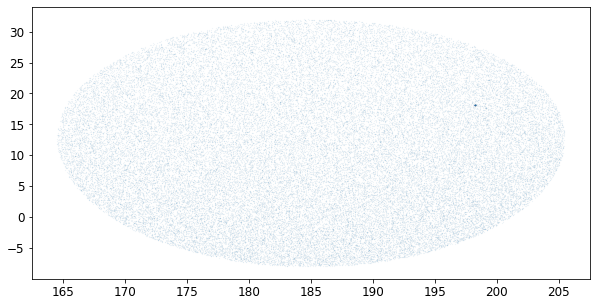

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.1, alpha=0.5)
plt.show()

In [6]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

13074 objects with invalid bp_rp


In [7]:
gaia[:3]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32
3972839289897271040,175.33439662974035,0.05191210944494655,16.448326687831226,0.03634290128494513,12.030033399069344,0.05149245447649511,-274.36118069089287,0.10621560395004459,-51.21439293774964,0.0643701011354351,0.1254669738812336,12.913276,2.4128094,49.05526871761382,7.633431178230264,NOT_AVAILABLE,3987.0999,nan
3972709719323995008,174.37060429554896,0.04183941064989952,16.545045804969167,0.03199713894303625,0.5669705322675835,0.052760614008978794,-9.39729294774048,0.07467773401770159,0.9378183868299208,0.05871267548761239,0.0,15.140601,0.7431507,nan,nan,NOT_AVAILABLE,6066.1196,0.3125
3972593720847082368,173.61702739987095,0.07503737420602331,16.195790209939982,0.07753651351765961,2.062479963443257,0.11376753310309651,-26.547890305809645,0.13545892864898715,-15.641838566056107,0.14518150887341377,0.0,16.357782,2.0100307,nan,nan,NOT_AVAILABLE,4197.0,1.524


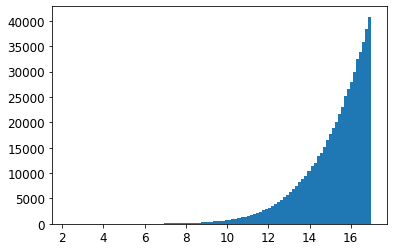

In [8]:
plt.hist(gaia['phot_g_mean_mag'], 100);

In [9]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    tmp = np.load('data/gaia_decals_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_spread = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['decals_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

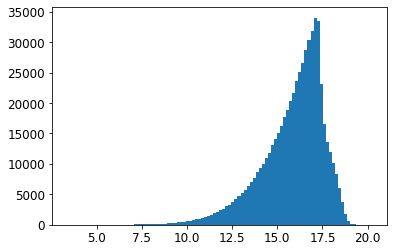

In [10]:
plt.hist(gaia['decals_g'], 100);

In [11]:
# mask = (gaia['phot_g_mean_mag']>16) & ((gaia['phot_g_mean_mag']<18))
# plt.figure(figsize=(8, 8))
# plt.plot((gaia['bp_rp'])[mask], (gaia['decals_g']-gaia['phot_g_mean_mag'])[mask], '.', ms=0.3)
# plt.xlabel('GAIA_BP - GAIA_RP')
# plt.ylabel('DECaLS_G - GAIA_G')
# plt.axis([-0.5, 3.5, -0.5, 3.])
# plt.grid(alpha=0.5)
# plt.show()

------
## Narrow bin of DECaLS g-band magnitude

In [12]:
decals_g_min_list = [10.5, 13.0, 15.5]
decals_g_max_list = [10.51, 13.01, 15.51]

In [13]:
radius_in_bin = []
flux_in_bin = []

for mag_index in range(len(decals_g_min_list)):
        
    decals_g_min, decals_g_max = decals_g_min_list[mag_index], decals_g_max_list[mag_index]
    print('\n', decals_g_min, decals_g_max)
    
    plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/04'    
    band = 'g'
    # img_type = '-resid'
    img_type = ''
    pixscale_str = '0.262'
    pixscale = float(pixscale_str)

    nsamp = 50

    idx = np.where((gaia['decals_g']>decals_g_min) & (gaia['decals_g']<decals_g_max))[0]
    print(len(idx))
    if len(idx)>nsamp:
        np.random.seed(1)
        idx = np.random.choice(idx, size=nsamp, replace=False)
        # print(len(idx))

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
    radius_arr = []
    flux_arr = []

    for index in idx:

        print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

        ra, dec = gaia['ra'][index], gaia['dec'][index]

        download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/'
        file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        if not os.path.isfile(file_path):
            url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}'.format(ra, dec, img_type, pixscale_str, band)
            cmd = 'wget -O '+file_path+' \"'+url+'\"'
            print(cmd)
            os.system(cmd)

        img_raw = fitsio.read(file_path)
        img = img_raw / (pixscale**2)

        grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
        xx, yy = np.meshgrid(grid, grid)
        radius = np.sqrt(xx**2 + yy**2).flatten()

        # Remove masked pixels
        mask = img.flatten()!=0
        radius = radius[mask]
        flux = img.flatten()[mask]

        bin_center, _, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., 31., 63))
        radius_arr.append(bin_center)
        flux_arr.append(bin_median)

        # vrange = 0.5
        # ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
        # ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
        # plt.close()

        # plt.figure(figsize=(8, 6))
        # plt.plot(radius, flux, '.', ms=0.5)
        # plt.plot(bin_center, bin_median, c='C1')
        # plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
        # plt.axis([0, 20, -1, 5])
        # plt.axhline(0, lw=1, color='r')
        # plt.grid(alpha=0.5)
        # plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
        # plt.close()

        # plt.figure(figsize=(8, 6))
        # plt.loglog(radius, flux, '.', ms=0.5)
        # plt.plot(bin_center, bin_median, c='C1')
        # plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
        # plt.axis([.5, 30, .02, 200])
        # plt.grid(alpha=0.5)
        # plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
        # plt.close()

    radius_arr = np.array(radius_arr)
    flux_arr = np.array(flux_arr)
    
    x, _, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., 31., 63))
    radius_in_bin.append(x)
    flux_in_bin.append(y)


 10.5 10.51
46
phot_g_mean_mag =  10.256024
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_6270_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=167.284748&dec=14.101546&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  9.907291
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_29236_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=186.602750&dec=9.417216&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  9.68104
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_32358_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=194.772197&dec=5.672438&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  10.106271
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_54507_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=189.531894&dec=5.633617&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  9.847165
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_59464_g_0.262.fits "http://legacysurvey.or

phot_g_mean_mag =  10.139065
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_437909_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=188.471635&dec=23.959942&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  10.0858965
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_455708_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=190.451007&dec=-2.890964&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  10.233981
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_495276_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=195.128988&dec=28.458613&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  10.165364
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_501139_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=194.607910&dec=29.457839&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  10.323667
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_558825_g_0.262.fits "http://legacysurvey.org/

phot_g_mean_mag =  12.648267
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_562475_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=182.044885&dec=22.219897&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  12.638706
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_98388_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=193.605697&dec=12.136308&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  12.621156
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_350099_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=198.776701&dec=21.080598&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  12.641547
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_512230_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=173.440750&dec=20.449242&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  12.675207
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_425717_g_0.262.fits "http://legacysurvey.org/vi

phot_g_mean_mag =  13.952973
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_56114_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=171.984564&dec=12.003873&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  14.635005
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_357220_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=182.271598&dec=20.486165&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  15.560068
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_125545_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=202.643729&dec=4.018189&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  15.114771
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_18957_g_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=166.657158&dec=7.957892&layer=dr8&pixscale=0.262&bands=g"
phot_g_mean_mag =  15.159952
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/gaia4/gaia_480128_g_0.262.fits "http://legacysurvey.org/viewe

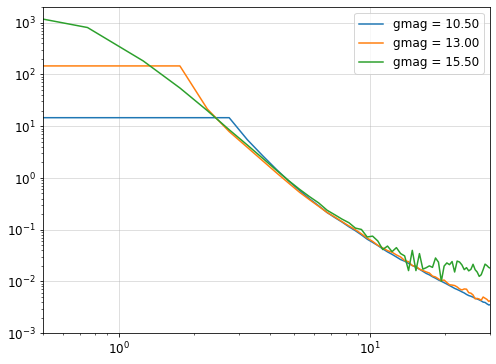

In [14]:
plt.figure(figsize=(8, 6))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((decals_g_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='gmag = {:.2f}'.format(decals_g_min_list[index]))
plt.axis([.5, 30, .001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

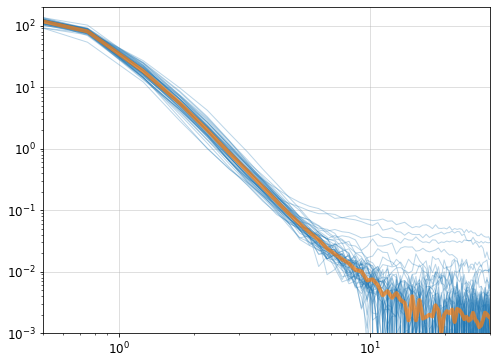

In [15]:
plt.figure(figsize=(8, 6))
plt.loglog(radius_arr.T, flux_arr.T, lw=1, alpha=0.3, c='C0')
plt.axis([.5, 30, .001, 200])
plt.grid(alpha=0.5)
x, _, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., 31., 63))
plt.loglog(x, y, lw=4, alpha=0.7, c='C1')
plt.show()